# SIR Model in SMT

This is an implementation for encoding the SIR-Model in SMT. The Z3 python binding was used.

## SIR Model
The SIR model is able to model the spread of a disease such as the Corona virus. The model consists of the following differential equations.

\begin{align}
\frac{dS}{dt} & = -\frac{\beta I S}{N} \\
\frac{dI}{dt} & = \frac{\beta I S}{N} - \gamma I \\
\frac{dR}{dt} & = \gamma I \\
N & = S + I + T
\end{align}

with a total population of $N$, and $S$ being the susceptable, $I$ the infected, and $R$ the recovered population. 

The infection rate depends on the following ratio called the reproduction number.
\begin{equation*}
R_0=\frac{\beta}{\gamma}
\end{equation*}


## Solution Approach
The SIR model is encoded in SMT and solved for discrete values using the SMT solver Z3.
As differential equations cannot be directly encoded in SMT, the differential equations are first transformed into difference equations.

\begin{align}
S(t + \Delta t) & = S(t) -\frac{\beta I(t) S(t)}{N} \\
I(t + \Delta t) & = \frac{\beta I(t) S(t)}{N} - \gamma I(t) \\
R(t + \Delta t) & = \gamma I(t)
\end{align}

These difference equations can then be encoded into SMT. And solved with a SMT solver.

I tried to encode the difference equations using quantified formulas, but my computer was not able to handle the computation. I decided to only solve the equations for only a couple of points and add the constraints individually for each point.


I am aware that this is by far not the best and most elegant approach to solve these differential equations, but I was curious to test, what a SMT solver was capable of.

In [32]:
#
# Author: Lukas Koller
# Date: 20.06.2020
#

# use z3 solver
from z3 import Solver, Function, IntSort, RealSort, sat

# size of the population
N = 100
# number of days for the simulation
number_of_days = 12

# susceptable
S = Function('S', IntSort(), RealSort())
# infected
I = Function('I', IntSort(), RealSort())
# recovered
R = Function('R', IntSort(), RealSort())

beta = 120
gamma = 0.4

# initialize a new solver
s = Solver()

# fix initial values
s.add(S(0) == (N-1)/N)
s.add(I(0) == 1/N)
s.add(R(0) == 0)

# add a constraints for S, I, & R for every day of the simulation
for t in range(number_of_days):
    s.add(1 == S(t + 1) + I(t + 1) + R(t + 1))
    s.add(S(t + 1) == S(t) - (beta * S(t) * I(t)) / N)
    # redundant constraint
    #s.add(I(t + 1) == I(t) + (beta * S(t) * I(t)) / N - gamma * I(t))
    s.add(R(t + 1) == R(t) + gamma * I(t))
    s.add(S(t) >= 0)
    s.add(I(t) >= 0)
    s.add(R(t) >= 0)

# check satisfiability
if s.check() != sat:
    raise Exception("not solvable!")

# retrieve the model
model = s.model()

<IPython.core.display.Javascript object>


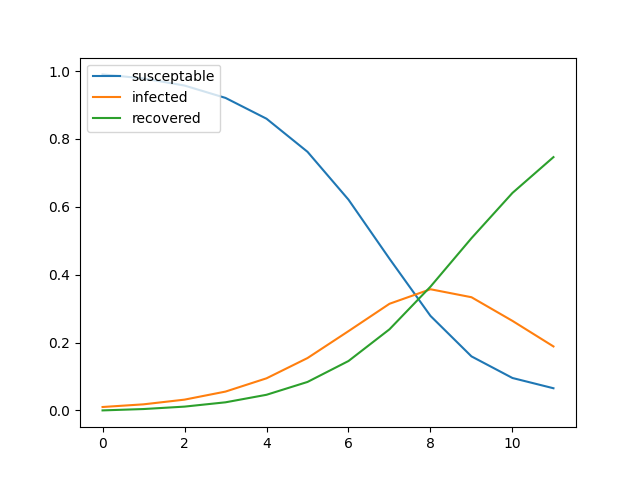

In [33]:
# plot the result
%matplotlib notebook
import matplotlib.pyplot as plt

S_vals = [float(model.evaluate(S(t)).numerator_as_long()/model.evaluate(S(t)).denominator_as_long()) for t in range(number_of_days)]
I_vals = [float(model.evaluate(I(t)).numerator_as_long()/model.evaluate(I(t)).denominator_as_long()) for t in range(number_of_days)]
R_vals = [float(model.evaluate(R(t)).numerator_as_long()/model.evaluate(R(t)).denominator_as_long()) for t in range(number_of_days)]

plt.plot(S_vals, label="susceptable")
plt.plot(I_vals, label="infected")
plt.plot(R_vals, label="recovered")
plt.legend(loc="upper left")
plt.show()